In [45]:
!pip install sklearn joblib imbalanced-learn


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-pypi-packag

In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib  # để lưu model
from imblearn.over_sampling import SMOTE

In [49]:

df = pd.read_csv(r"D:\NCKH\estimate_question_difficulty\training\merged.csv")
X = df.drop(columns=["id", "Bloom_Label"])
y = df["Bloom_Label"]
# ⚖️ Cân bằng dữ liệu bằng SMOTE
smote = SMOTE(random_state=42, k_neighbors=1)  # k_neighbors=1 vì có lớp chỉ có 3 mẫu
X_resampled, y_resampled = smote.fit_resample(X, y)

# # Kiểm tra số lượng mẫu trong từng class
# class_counts = y.value_counts()
# print("📊 Số lượng mẫu trong từng class:\n", class_counts)

# # Phát hiện class nào có < 2 mẫu
# rare_classes = class_counts[class_counts < 2]
# if not rare_classes.empty:
#     print("\n⚠️ Các lớp có ít hơn 2 mẫu, có thể gây lỗi khi stratify:")
#     print(rare_classes)

# # Bước 1: train (70%) + temp (30%)
# X_train, X_temp, y_train, y_temp = train_test_split(
#     X, y,
#     test_size=0.3,
#     stratify=y,        # giữ tỷ lệ class trong train
#     random_state=42
# )

# # Bước 2: từ temp (30%) chia thành val (20%) và test (10%)
# # => test_size = 10 / (20+10) = 1/3
# try:
#     X_val, X_test, y_val, y_test = train_test_split(
#         X_temp, y_temp,
#         test_size=1/3,
#         stratify=y_temp,   # có thể lỗi nếu class quá ít
#         random_state=42
#     )
# except ValueError:
#     print("\n⚠️ Có lớp quá ít mẫu => bỏ stratify khi chia val/test.")
#     X_val, X_test, y_val, y_test = train_test_split(
#         X_temp, y_temp,
#         test_size=1/3,
#         random_state=42
#     )

# print("\n✅ Kích thước tập dữ liệu:")
# print("Train:", len(X_train))
# print("Validation:", len(X_val))
# print("Test:", len(X_test))

# Trọng số cho từng feature
weights = {
    "mean_sim": 2.0,
    "max_sim": 2.0,
    "min_sim": 2.0,
    "std_sim": 2.0,
    "range_sim": 2.0,
    "sentence_length": 1,
    "avg_word_length": 1,
    "num_clauses": 1.5,
    "num_punct": 0,
    "num_nouns": 1.2,
    "num_verbs": 1.2,
    "num_adjs": 1.2,
    "perplexity": 2.0
}

# Nhân trọng số
for col, w in weights.items():
    if col in X.columns:
        X[col] = X[col] * w

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Bước 2: từ temp (30%) chia thành val (20%) và test (10%)
# tỉ lệ test_size = 10 / (20+10) = 1/3
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42
)
# clf = RandomForestClassifier(
#     n_estimators=200,   # số cây (càng nhiều càng chính xác nhưng chậm)
#     max_depth=None,    # cho phép cây phát triển đầy đủ
#     random_state=42
#     ,oob_score=True
# )



In [50]:
print(y.value_counts(normalize=True))

Bloom_Label
Remember      0.456140
Understand    0.385965
Analyze       0.105263
Apply         0.052632
Name: proportion, dtype: float64


In [51]:
# Định nghĩa các tham số cần thử
param_grid = {
    "n_estimators": [500, 600,700],         # số cây
    "max_depth": [None, 10, 20, 30],         # độ sâu tối đa
    "min_samples_split": [4, 5, 7],         # số mẫu tối thiểu để split
    "max_features": ["sqrt", "log2","none"],        # số feature dùng khi split
    "class_weight": [None, "balanced"]       # cân bằng dữ liệu hay không
}
rf = RandomForestClassifier(random_state= 20)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv= 10,               # 5-fold cross-validation
    n_jobs=-1,          # chạy song song nhiều CPU core
    verbose=2,
    scoring="f1_macro"  # có thể đổi sang "f1_macro" nếu dữ liệu mất cân bằng
)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

# Dùng model tốt nhất để test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nBáo cáo phân loại:\n", classification_report(y_test, y_pred))
# clf.fit(X_train, y_train)
# # Dự đoán
# y_pred = clf.predict(X_test)
# # Đánh giá mô hình
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("\nBáo cáo phân loại:\n", classification_report(y_test, y_pred))

joblib.dump(best_model, r"D:\NCKH\estimate_question_difficulty\training\random_forest_best.pkl")
print("✅ Đã lưu mô hình vào random_forest_best.pkl")

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


c:\Users\quang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\quang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
720 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
289 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\quang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\quan

Best Parameters: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 500}
Best CV Accuracy: 0.4127777777777778
Test Accuracy: 0.8333333333333334

Báo cáo phân loại:
               precision    recall  f1-score   support

     Analyze       0.00      0.00      0.00         1
       Apply       1.00      1.00      1.00         1
    Remember       1.00      1.00      1.00         3
  Understand       0.50      1.00      0.67         1

    accuracy                           0.83         6
   macro avg       0.62      0.75      0.67         6
weighted avg       0.75      0.83      0.78         6

✅ Đã lưu mô hình vào random_forest_best.pkl


c:\Users\quang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\quang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\quang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

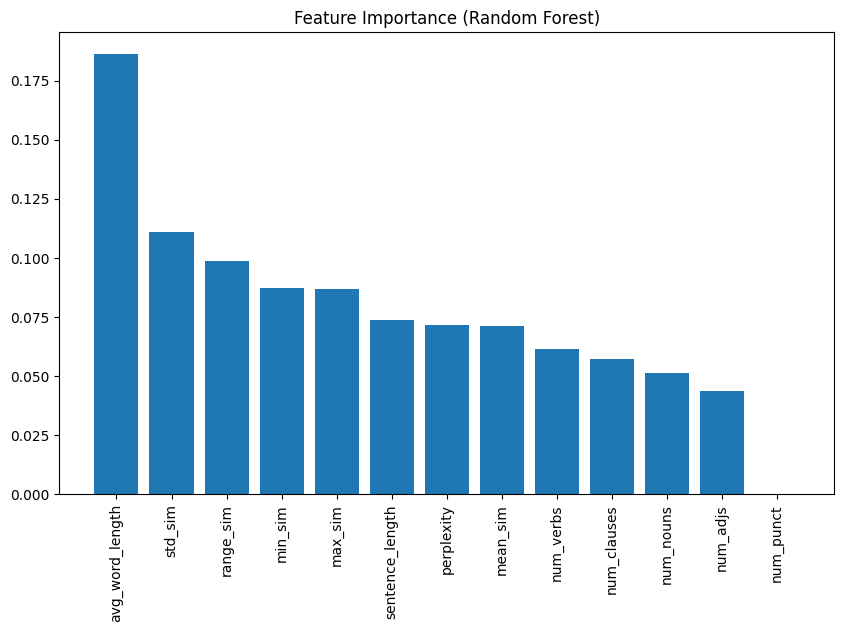

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.title("Feature Importance (Random Forest)")
plt.show()

In [ ]:
from sklearn.model_selection import cross_validate
import numpy as np

# Đánh giá mô hình với 10-fold CV
cv_results = cross_validate(
    best_model, 
    X, y, 
    cv=10, 
    scoring=["accuracy", "precision_macro", "recall_macro", "f1_macro"],
    n_jobs=-1,
    return_train_score=True
)

# In kết quả trung bình + độ lệch chuẩn
print("\n--- Đánh giá bằng 10-fold Cross-Validation ---")
for metric in ["train_accuracy", "test_accuracy", 
               "train_precision_macro", "test_precision_macro", 
               "train_recall_macro", "test_recall_macro", 
               "train_f1_macro", "test_f1_macro"]:
    mean_score = np.mean(cv_results[metric])
    std_score = np.std(cv_results[metric])
    print(f"{metric}: {mean_score:.4f} ± {std_score:.4f}")

c:\Users\quang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(



--- Đánh giá bằng 10-fold Cross-Validation ---
train_accuracy: 0.9844 ± 0.0117
test_accuracy: 0.6167 ± 0.2104
train_precision_macro: 0.9904 ± 0.0071
test_precision_macro: 0.6114 ± 0.2957
train_recall_macro: 0.9912 ± 0.0069
test_recall_macro: 0.5764 ± 0.2467
train_f1_macro: 0.9907 ± 0.0070
test_f1_macro: 0.5556 ± 0.2707
